# Advanced Constellation

This example showcases how the constellation utility functions can be leveraged to instantiate a constellation. In this example, a co-planar constellation of five spacecraft is created. Each spacecraft is initialised with a random pointing angle and then commanded to point consistently according to their local Local-Vertical, Local-Horizontal frame.

In [5]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from nominalpy import types
from nominalpy.maths import value, astro, utils
from nominalpy.maths.constants import RPM
# from nominalpy.maths.utils import random_mrp
from nominalpy.maths.constellations import CoplanarCircular
from nominalpy import Component, Simulation, Object

import credential_helper

In [6]:
# define the configuration of the scenario
num_spacecraft: int = 5
sma0: float = 7000e3 # meters
inc0: float = np.radians(45) # radians
raan0: float = np.radians(35) # radians


The components for each spacecraft can be stored in their own separate containers. By storing the component for each spacecraft, the component can be accessed later to connect messages and retrieve data.

In [7]:
# define the containers for the data for all of the spacecraft
ext_torque: list = []
spacecraft: list = []
navigators: list = []
attitude_tracking_error_fsws: list = []
mrp_feedback_fsws: list = []
lvlh_fsws: list = []
ephem_converter_fsws: list = []

In [8]:
# Construct the credentials
credentials = credential_helper.fetch_credentials()

# Create a simulation handle
simulation: Simulation = Simulation(credentials)

In [9]:
universe: Object = simulation.get_system(
    types.UNIVERSE,
    Epoch=value.datetime(2021, 1, 15, hour=0, min=28, sec=30)
)

The co-planar constellation utility class allows the user to calculate the initial state of the spacecraft equispaced about a single plane. The size and orientation of the orbital plane is defined by its semi-major axis, inclination, and right-ascension of the ascending node. Other orbital elements can further define the nature of the orbits and orbital plane, however are not included in this example.

In [10]:
# define a coplanar constellation of spacecraft using the utility function provided in nominalpy
cons = CoplanarCircular(
    semi_major_axis=sma0,
    inclination=inc0,
    right_ascension=raan0,
    argument_of_periapsis=np.radians(25),
    true_anomaly=0.0,
    num_satellites=num_spacecraft,
    init_classical_elements=True,
)

The initial state of each spacecraft in the orbit can be returned as orbital elements or state vectors. They can also be calculated as osculating orbital values or the equivalent mean orbital elements/mean state vector. In this case we calculate the state vector directly in its osculating state.

In [11]:
# define a function to generate a random MRP vector for the initial attitude of the spacecraft

def random_mrp():
    """
    Generate a random MRP vector. This function generates a random MRP vector
    using the numpy random function. The MRP vector is generated by generating
    a random vector and normalizing it.

    :returns:   The random MRP vector
    :rtype:     np.ndarray
    """
    # Generate a random rotation axis (unit vector)
    axis: float = np.random.rand(3)
    axis /= np.linalg.norm(axis)

    # Generate a random rotation angle in radians
    angle: float = np.random.uniform(0, 2 * np.pi)

    # Convert angle-axis to quaternion
    q0: float = np.cos(angle / 2)
    q_vec: float = axis * np.sin(angle / 2)

    # Convert quaternion to MRP
    mrp = q_vec / (1 + q0)
    # return the random mrp
    return mrp


In [12]:
for _, vectors in cons.init_state_vectors_osculating(planet="earth").items():
    # create the spacecraft and initialise it with its orbit
    sc = simulation.add_component(
        types.SPACECRAFT,
        TotalMass=4.0,  # kg
        TotalCenterOfMassB_B=np.array((0, 0, 0)),
        TotalMomentOfInertiaB_B=np.diag([0.02 / 3.0, 0.1256 / 3.0, 0.1256 / 3.0]),  # kg m^2
        Position=vectors["r_bn_n"],
        Velocity=vectors["v_bn_n"],
        # set default values, these will have to be updated for every test case
        Attitude=random_mrp(),
        AttitudeRate=np.array((0.0, 0.0, 0.0))
    )
    spacecraft.append(sc)
    

In [13]:
# set the flight software for every spacecraft in the constellation
for i, sc in enumerate(spacecraft):

    # set the navigation flight software
    navigators.append(
        simulation.add_component(
            "SimpleNavigator",
            sc,
            In_BodyStateMsg=sc.get_message("Out_BodyStatesMsg").id,
            In_SunStateMsg=simulation.get_planet_message(planet="sun").id,
        )
    )
    # add the flight software to convert Earth location to a useable ephemeris
    ephem_converter_fsws.append(
        simulation.add_component(
            "EphemerisNavigationConverterSoftware",
            sc,
            In_SpicePlanetStateMsg=simulation.get_planet_message(planet="earth").id,
        )
    )
    # add the LVLH reference frame flight software
    lvlh_fsws.append(
        simulation.add_component(
            "LVLHPointingSoftware",
            sc,
            In_NavTransMsg=navigators[i].get_message("Out_NavTransMsg").id,
            In_EphemerisMsg=ephem_converter_fsws[i].get_message("Out_EphemerisMsg").id,
        )
    )
    # add the tracking error software
    attitude_tracking_error_fsws.append(
        simulation.add_component(
            "AttitudeTrackingErrorSoftware",
            sc,
            In_NavAttMsg=navigators[i].get_message("Out_NavAttMsg").id,
            In_AttRefMsg=lvlh_fsws[i].get_message("Out_AttRefMsg").id,
        )
    )
    # add the MRP feedback software
    ki = -1.0
    decay_time = 10.0
    xi = 1.0
    P = (0.1256 / 3) / decay_time
    mrp_feedback_fsws.append(
        simulation.add_component(
            "MRPFeedbackSoftware",
            sc,
            K=(P / xi) * (P / xi) / (0.1256 / 3),
            P=P,
            Ki=ki,
            IntegralLimit=2.0 / ki * 0.1,
            In_AttGuidMsg=attitude_tracking_error_fsws[i].get_message("Out_AttGuidMsg").id,
            In_VehicleConfigMsg=sc.get_message("Out_VehicleConfigMsg").id,
        )
    )
    # connect the external force torque to the mrp feedback software
    # add the external force torque
    ext_torque.append(
        simulation.add_component(
            "ExternalForceTorque",
            sc,
            In_CmdTorqueBodyMsg=mrp_feedback_fsws[i].get_message("Out_CmdTorqueBodyMsg").id,
        )
    )


In [14]:
subscribe_step = 5.0
for k, sc in enumerate(spacecraft):
    sc.get_message("Out_BodyMassPropsMsg").subscribe(subscribe_step)
    sc.get_message("Out_BodyStatesMsg").subscribe(subscribe_step)
    attitude_tracking_error_fsws[k].get_message("Out_AttGuidMsg").subscribe(subscribe_step)
    mrp_feedback_fsws[k].get_message("Out_CmdTorqueBodyMsg").subscribe(subscribe_step)
    navigators[k].get_message("Out_NavAttMsg").subscribe(subscribe_step)


In [15]:
# run the scenario
simulation.tick_duration(duration=400, step=0.1)

In [16]:
# fetch the data as a dataframe and concatenate the frames into a single frame for each spacecraft
dfs_att = [at.get_message("Out_AttGuidMsg").fetch_df() for at in attitude_tracking_error_fsws]
df_att0 = dfs_att[0]
df_body_state = pd.concat([sc.get_message("Out_BodyStatesMsg").fetch_df() for sc in spacecraft])
df_att = pd.concat(
    [at.get_message("Out_AttGuidMsg").fetch_df() for at in attitude_tracking_error_fsws],
    keys=[i for i in range(len(attitude_tracking_error_fsws))]
)
# set the names of the indices
df_att.index = df_att.index.set_names(["sc_num", "index"])
df_att = df_att.reset_index(drop=False).set_index(["sc_num", "time"]).drop(columns=["index"])


If we plot the magnitude of the attitude tracking error for all spacecraft on one plot, we can see that the attitude of the spacecraft converges onto the target attitude for all spacecraft irrespective of their initial attitude.

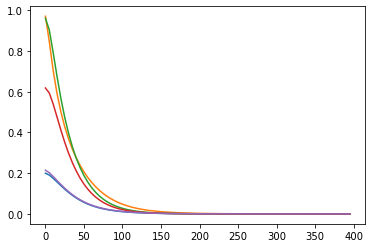

In [17]:
# plot the magnitude of the attitude tracking error for each spacecraft in the constellation
fig, ax = plt.subplots()
for j, sc in enumerate(spacecraft):
    ax.plot(
        df_att.loc[df_att.index.get_level_values("sc_num") == j].index.get_level_values("time").values,
        np.linalg.norm(
            df_att.loc[df_att.index.get_level_values("sc_num") == j, ["Sigma_BR_0", "Sigma_BR_1", "Sigma_BR_2"]],
            axis=1
        ),
        label=f"Spacecraft {j + 1}"
    )
